# Working with Variational Distributions

We'll illustrate how to use the `VariationalDist` and `VariationalDistSpec` objects in tandem with the `Encoder` to perform sampling and compute the NLL. Let's load and simulate some data according to the `base_config`.

In [1]:
import sys
import os
os.chdir('/home/songju/bliss')
from bliss.encoder.variational_dist import VariationalDistSpec, VariationalDist
from bliss.encoder.unconstrained_dists import UnconstrainedNormal
import torch
import numpy as np
from os import environ
from pathlib import Path
from hydra import initialize, compose
from hydra.utils import instantiate
import matplotlib.pyplot as plt
from omegaconf import DictConfig, OmegaConf
from bliss.catalog import TileCatalog

environ["BLISS_HOME"] = "/home/songju/bliss"
with initialize(config_path="../../bliss/conf", version_base=None):
    cfg = compose("base_config", overrides={"surveys.sdss.load_image_data=true"})

In [2]:
simulator = instantiate(cfg.simulator)

In [3]:
type(simulator)

bliss.simulator.simulated_dataset.SimulatedDataset

#### This cell below will take several minutes to run.

In [4]:
test_batch = simulator.get_batch()

In [5]:
test_batch.keys()

dict_keys(['tile_catalog', 'images', 'background', 'deconvolution', 'psf_params'])

In [6]:
test_batch['tile_catalog'].keys()

dict_keys(['locs', 'n_sources', 'source_type', 'galaxy_fluxes', 'galaxy_params', 'star_fluxes'])

Let's instaniate the `Encoder` and run its primary method (for our purposes): the `infer` method that operates on simulated batches of data. More precisely, infer operates on the images of the batch (`test_batch['images']` in our naming so far). First, let's hard-code the so-called `target_cat` aka target catalog to be the ground truth $z$. We need this to construct the variable `truth_callback` below (we won't worry too much about the motivation behind this for now).

In [7]:
encoder = instantiate(cfg.train.encoder)
target_cat = TileCatalog(encoder.tile_slen, test_batch["tile_catalog"])

In [8]:
target_cat

TileCatalog(64 x 20 x 20)

In [9]:
# filter out undetectable sources
if encoder.min_flux_threshold > 0:
    target_cat = target_cat.filter_tile_catalog_by_flux(min_flux=encoder.min_flux_threshold)
    
# make predictions/inferences
target_cat1 = target_cat.get_brightest_sources_per_tile(band=2, exclude_num=0)
truth_callback = lambda _: target_cat1
pred = encoder.infer(test_batch, truth_callback)

Let's examine the outputs of the `infer` method.

In [10]:
pred.keys()

dict_keys(['x_features', 'marginal', 'history_cat', 'white_history_mask', 'white', 'black'])

We'll be most concerned with the dict entry `marginal`. As the name suggests, this will contain all information necessary for constructing the marginal variational distributions. In general, if a variational family is mean-field, it factorizes as the product of the marginals

$$
q(z_1, z_2 \mid x) = q(z_1 \mid x) q(z_2 \mid x)
$$

hence the naming. For each latent variable of interest, we just need to know the marginal variational distribution on it when using this particular form of mean-field variational family. BLISS uses this type of variational family for the most part, although there are some subtleties whereby adjacent tiles do interact with one another. Let's focus on the pure mean-field case for now. If we have a distribution on each latent variable of interest, we can compute

$$
\log q(z_1, \dots, z_K \mid x) = \sum_{i=1}^K \log q(z_i \mid x)
$$

by log properties. We shall see that this is essentially how the `VariationalDist` objects compute the NLL.

In [11]:
type(pred['marginal'])

bliss.encoder.variational_dist.VariationalDist

In [12]:
pred['marginal'].factors

{'on_prob': Categorical(probs: torch.Size([64, 20, 20, 2])),
 'loc': TruncatedDiagonalMVN(Normal(loc: torch.Size([64, 20, 20, 2]), scale: torch.Size([64, 20, 20, 2]))),
 'galaxy_prob': Categorical(probs: torch.Size([64, 20, 20, 2])),
 'galsim_disk_frac': TransformedDistribution(),
 'galsim_beta_radians': TransformedDistribution(),
 'galsim_disk_q': TransformedDistribution(),
 'galsim_a_d': LogNormal(),
 'galsim_bulge_q': TransformedDistribution(),
 'galsim_a_b': LogNormal(),
 'star_flux_u': LogNormal(),
 'star_flux_g': LogNormal(),
 'star_flux_r': LogNormal(),
 'star_flux_i': LogNormal(),
 'star_flux_z': LogNormal(),
 'galaxy_flux_u': LogNormal(),
 'galaxy_flux_g': LogNormal(),
 'galaxy_flux_r': LogNormal(),
 'galaxy_flux_i': LogNormal(),
 'galaxy_flux_z': LogNormal()}

We see that `pred['marginal']` returns an object of type `VariationalDist`. This variational distribution is conditional on the $x$ defined by our particular simulated batch.

The `factors` attribute contains each of the marginal factors. Some of the shapes are revealing. Clearly 64 x 20 x 20 corresponds to the number of images in a simulated batch and the tiles corresponding to the `base_config` we've used. These can be altered if desired.

In [13]:
cfg.prior.batch_size, cfg.prior.n_tiles_h, cfg.prior.n_tiles_w

(64, 20, 20)

This informs some of the dimensions we see above. For example, `loc` should 2D ***per-source***, an (x,y) coordinate pair. Hence the 2 in the last dimension for `loc`. Evidently, many of these distributions are per-source.

Recall that BLISS's variational distribution currently allows for at most 2 sources per tile. This does not seem to be accounted for in the above. The way BLISS works in reality is to first detect the brightest source in each tile; then, having accounted for this, try to find a second source. In this `base_config` we don't do this actually: the prior is constrained to have at most 1 source per-tile so it's not necessary. If one wanted to detect multiple sources per-tile, one could change by overwriting as below. To detect multiple sources, one needs to implement this two-stage process. This can be done by setting the configurable `encoder.double_detect` to be `True` (and potentially some other configurables).

For now, we won't worry about this and will be satisfied with generating and detecting at most 1 source per tile.

In [14]:
print(cfg.prior.max_sources) # Should be =1
print(cfg.encoder.double_detect) #Should be False

1
False


In [15]:
# Would change these configurables to detect multiple sources via a two-layer detection stage in encoder.
# cfg.prior.max_sources = 2
# cfg.encoder.double_detect = True

How does the `infer` method of `Encoder` produce a `VariationalDist` object? Through the `VariationalDistSpec` class. This "variational distribution specificiation" contains the information needed to construct the variational distribution. Here's a look at the class below. The most important attribute is `factor_specs` which specifies the factors for each latent variable of interest.

```
class VariationalDistSpec(torch.nn.Module):
    def __init__(self, survey_bands, tile_slen):
        super().__init__()

        self.survey_bands = survey_bands
        self.tile_slen = tile_slen

        self.factor_specs = {
            "on_prob": UnconstrainedBernoulli(),
            "loc": UnconstrainedTDBN(),
            "galaxy_prob": UnconstrainedBernoulli(),
            # galsim parameters
            "galsim_disk_frac": UnconstrainedLogitNormal(),
            "galsim_beta_radians": UnconstrainedLogitNormal(high=torch.pi),
            "galsim_disk_q": UnconstrainedLogitNormal(),
            "galsim_a_d": UnconstrainedLogNormal(),
            "galsim_bulge_q": UnconstrainedLogitNormal(),
            "galsim_a_b": UnconstrainedLogNormal(),
        }
...
```

The `Encoder` is instantiated with a `VariationalDistSpec` attribute. The `infer` method then uses the `make_dist` method of `VariationalDistSpec` to create the `VariationalDist` object.

In [16]:
encoder.vd_spec

VariationalDistSpec()

We will present just a little more detail on how `Encoder` produces the final variational distribution. Look inside `Encoder.infer` for more detail. 

For any given batch, the images are first normalized, then passed through a feature net. 

In [17]:
normalized_images = encoder.image_normalizer.get_input_tensor(test_batch)
x_features = encoder.features_net(normalized_images)
x_features.shape

torch.Size([64, 256, 20, 20])

It appears that each tile is represented by a vector of length 256. This tensor is then passed to `marginal_net`  which produces all necessary variational parameters.

In [18]:
x_cat = encoder.marginal_net(x_features)
x_cat.shape

torch.Size([64, 20, 20, 38])

The shape of `x_cat` is revealing. It tells us that per-tile, we have 38 variational parameters. Let's recover this number 38 from the variational distribution specification to check that everything matches.

In [19]:
sum(dist.dim for _,dist in encoder.vd_spec.factor_specs.items() )

38

So this magical number 38 just matches the dimensions totaled by all the variational distributions. If we added more variational distributions, this number would have to change obviously (it would increase, to 40, 45, etc.

Let's show how `VariationalDist` is created from `x_cat`. As said above, this is done using the `make_dist` method of `VariationalDistSpec`.

```
def make_dist(self, x_cat):
    factors = self._parse_factors(x_cat)
    return VariationalDist(factors, self.survey_bands, self.tile_slen)

```

In [20]:
vd = encoder.vd_spec.make_dist(x_cat)

Once one has the `VariationalDist` object created, one can compute NLL and sample using the functions quite easily.

In [21]:
vd.compute_nll(target_cat1).shape

torch.Size([64, 20, 20])

In [22]:
vd.sample(use_mode=True)

TileCatalog(64 x 20 x 20)

# Redshift-Focused Variational Distributions

I've extended the `VariationalDistSpec` and `VariationalDist` classes to `RedshiftVariationalDistSpec` and `RedshiftVariationalDist`. The main differences between these is that they add a new variational distribution on redshift to the list of parameters above. The config `redshift.yaml` extends the `base_config.yaml` so similarly both generates and detects at most one source per tile. We can make it more complicated later.

In [7]:
from catalog import RedshiftTileCatalog
from variational_dist import RedshiftVariationalDistSpec, RedshiftVariationalDist

environ["BLISS_HOME"] = "/home/songju/bliss"
with initialize(config_path=".", version_base=None):
    cfg = compose("redshift", overrides={"surveys.sdss.load_image_data=true"})

In [8]:
simulator = instantiate(cfg.simulator)
test_batch = simulator.get_batch()
test_batch['tile_catalog'].keys()

dict_keys(['locs', 'n_sources', 'source_type', 'galaxy_fluxes', 'galaxy_params', 'star_fluxes', 'redshifts'])

In [9]:
encoder = instantiate(cfg.train.encoder)
target_cat = RedshiftTileCatalog(encoder.tile_slen, test_batch["tile_catalog"])

In [10]:
type(encoder)

bliss.encoder.encoder.Encoder

We do not need to modify/extend the Encoder class at this point in time.

In [11]:
# filter out undetectable sources
if encoder.min_flux_threshold > 0:
    target_cat = target_cat.filter_tile_catalog_by_flux(min_flux=encoder.min_flux_threshold)
    
# get brightest sources
target_cat1 = target_cat.get_brightest_sources_per_tile(band=2, exclude_num=0)

Let's make an example `RedshiftVariationalDistSpec` object to illustrate the new `factor_spec` on redshift.

In [12]:
rvds = RedshiftVariationalDistSpec(cfg.prior.survey_bands, cfg.prior.tile_slen)

In [13]:
list(rvds.factor_specs.items())

[('on_prob',
  <bliss.encoder.unconstrained_dists.UnconstrainedBernoulli at 0x7f8992399540>),
 ('loc',
  <bliss.encoder.unconstrained_dists.UnconstrainedTDBN at 0x7f8992399510>),
 ('galaxy_prob',
  <bliss.encoder.unconstrained_dists.UnconstrainedBernoulli at 0x7f8992399270>),
 ('galsim_disk_frac',
  <bliss.encoder.unconstrained_dists.UnconstrainedLogitNormal at 0x7f89923995a0>),
 ('galsim_beta_radians',
  <bliss.encoder.unconstrained_dists.UnconstrainedLogitNormal at 0x7f8992399ab0>),
 ('galsim_disk_q',
  <bliss.encoder.unconstrained_dists.UnconstrainedLogitNormal at 0x7f89923999f0>),
 ('galsim_a_d',
  <bliss.encoder.unconstrained_dists.UnconstrainedLogNormal at 0x7f8992399a50>),
 ('galsim_bulge_q',
  <bliss.encoder.unconstrained_dists.UnconstrainedLogitNormal at 0x7f8992399c90>),
 ('galsim_a_b',
  <bliss.encoder.unconstrained_dists.UnconstrainedLogNormal at 0x7f8992399600>),
 ('star_flux_u',
  <bliss.encoder.unconstrained_dists.UnconstrainedLogNormal at 0x7f8992399c00>),
 ('star_flux_

We see that `rvds.factor_specs` contains a new variational distribution unique for this project, a distribution redshift. It's a Gaussian distribution for now, but be made to be anything one desires.

The `Encoder` object should have a `RedshiftVariationalDistSpec` as its `vd_spec` attribute now. This was done by changing the appropriate `_target_` in the config.

In [14]:
encoder.vd_spec

RedshiftVariationalDistSpec()

Using the output of `Encoder.infer` thus get an instance of `RedshiftVariationalDist` that we can use to compute the NLL and sample, etc.

In [15]:
truth_callback = lambda _: target_cat1
pred = encoder.infer(test_batch, truth_callback)

In [16]:
pred['marginal']

RedshiftVariationalDist()

In [17]:
sum(dist.dim for _,dist in encoder.vd_spec.factor_specs.items() )

40

There are now 40 variational parameters per source, up from 38 before. We added two: a location and scale parameter for the Gaussian distribution that describes redshift.

Let's compute NLL and sample to make sure everything works.

In [18]:
rvd = pred['marginal']

In [19]:
rvd.sample(use_mode=True)

RedshiftTileCatalog(64 x 20 x 20)

In [20]:
rvd.compute_nll(target_cat1).shape

torch.Size([64, 20, 20])

### Example Training Loop

***This cell runs pretty slowly. All on CPU for illustration.***

In [21]:
niter = 300
optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-3)
for i in range(niter):
    # Many of the lines below are redundant because we have a single batch
    # so quantities don't change.
    
    target_cat = RedshiftTileCatalog(encoder.tile_slen, test_batch["tile_catalog"])
    # filter out undetectable sources
    if encoder.min_flux_threshold > 0:
        target_cat = target_cat.filter_tile_catalog_by_flux(min_flux=encoder.min_flux_threshold)

    # make predictions/inferences
    target_cat1 = target_cat.get_brightest_sources_per_tile(band=2, exclude_num=0)
    truth_callback = lambda _: target_cat1
    pred = encoder.infer(test_batch, truth_callback)
    rvd = pred['marginal']
    
    # Main gradient step code
    optimizer.zero_grad()
    loss = rvd.compute_nll(target_cat1).mean()
    loss.backward()
    optimizer.step()
    
    if i % 10 == 0:
        print('Iteration {}: Loss {}'.format(i, loss.item()))
    

Iteration 0: Loss 8.25091552734375
Iteration 10: Loss 5.093790054321289
Iteration 20: Loss 4.310693264007568
Iteration 30: Loss 4.058763027191162
Iteration 40: Loss 3.886284589767456
Iteration 50: Loss 3.7290303707122803
Iteration 60: Loss 3.637453079223633
Iteration 70: Loss 3.454812526702881
Iteration 80: Loss 3.299492597579956
Iteration 90: Loss 3.199141263961792
Iteration 100: Loss 2.900380849838257
Iteration 110: Loss 2.894904136657715
Iteration 120: Loss 2.89668345451355
Iteration 130: Loss 2.3122503757476807
Iteration 140: Loss 2.3543496131896973
Iteration 150: Loss 2.284011125564575
Iteration 160: Loss 2.9628548622131348
Iteration 170: Loss 2.34633731842041
Iteration 180: Loss 2.2365896701812744
Iteration 190: Loss 1.59198796749115
Iteration 200: Loss 1.9312080144882202
Iteration 210: Loss 1.2370305061340332
Iteration 220: Loss 1.856213092803955
Iteration 230: Loss 1.0501872301101685
Iteration 240: Loss 3.6987011432647705
Iteration 250: Loss 2.416386604309082
Iteration 260: Los

Let's check how we're doing on the redshift variational distributions. Recall the prior on redshift is extremely concentrated as this is a toy case for now.

In [24]:
cfg.prior.redshift_alpha, cfg.prior.redshift_beta

(3, 3.33333333333333)

In [25]:
q = rvd.factors
q["redshift"].loc.flatten()

tensor([0.7259, 0.6379, 1.1623,  ..., 0.7594, 0.7875, 0.9368],
       grad_fn=<UnsafeViewBackward0>)

In [26]:
q["redshift"].scale.flatten()

tensor([0.3079, 0.4050, 0.4829,  ..., 0.2468, 0.2095, 0.1621],
       grad_fn=<ReshapeAliasBackward0>)

The locations are looking pretty good; the scales are still way too big, but at least the variational distributions are overdispersed. The variational distribution is misspecified: the prior is $\textrm{Unif}(0.99, 1.01)$, and we have not modified the decoder $p(x \mid z)$ at all. In other words, redshift has no impact on the data right now. Accordingly, the posterior should be equal to the prior.

Of course we don't achieve that, because the variational distribution is constained to be Gaussian. We'd hope with more trainin we could get even more highly concentrated Gaussians approximately in the interval $[0.99,1.01]$ but the above suffices for now as a sanity check.

In [1]:
from scipy.stats import gamma

In [29]:
import matplotlib.pyplot as plt

(array([7.400e+01, 2.030e+03, 9.093e+03, 9.687e+03, 3.734e+03, 8.030e+02,
        1.430e+02, 2.300e+01, 1.100e+01, 2.000e+00]),
 array([-0.24583179,  0.1135107 ,  0.47285318,  0.83219564,  1.1915381 ,
         1.55088067,  1.91022313,  2.26956558,  2.62890816,  2.98825049,
         3.34759307]),
 <BarContainer object of 10 artists>)

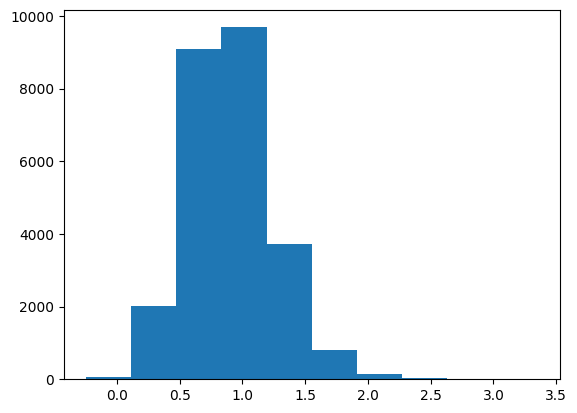

In [34]:
plt.hist(q["redshift"].loc.detach().numpy().flatten())

Test other prior

In [6]:
import prior
prior.CatalogPrior()._sample_galaxy_prior()

TypeError: CatalogPrior.__init__() missing 24 required positional arguments: 'survey_bands', 'n_tiles_h', 'n_tiles_w', 'tile_slen', 'batch_size', 'min_sources', 'max_sources', 'mean_sources', 'prob_galaxy', 'star_flux_exponent', 'star_flux_truncation', 'star_flux_loc', 'star_flux_scale', 'galaxy_flux_exponent', 'galaxy_flux_truncation', 'galaxy_flux_loc', 'galaxy_flux_scale', 'galaxy_a_concentration', 'galaxy_a_loc', 'galaxy_a_scale', 'galaxy_a_bd_ratio', 'star_color_model_path', 'gal_color_model_path', and 'reference_band'